# PageRank

Let's implement PageRank and test it with a small web graph.

First some imports.

In [1]:
import math
import time
import networkx as nx # graphs
import numpy as np  # scientific computing, array class
import scipy.sparse as sp  # sparse matrices
import matplotlib.pyplot as plt # plotting
plt.style.use("seaborn-v0_8") # let's have nice plots

We download a very small part of the web from 2008 (?): namely the web of Berkley and Stanford University websites. See [here](https://networkrepository.com/web-BerkStan-dir.php) for more details. 

If you run this on your own Windows machine (rather than on Colab), you may need to [download](https://networkrepository.com/web-BerkStan-dir.php) the data manually. In that case, comment out the next cell. If you run this on your own Linux machine -- nice! Also, just run the next cell. (Apple may work as well.)

In [ ]:
!wget -q --show-progress https://nrvis.com/download/data/web/web-BerkStan-dir.zip
!unzip -q web-BerkStan-dir.zip

Let's have a peek into the data.

In [2]:
counter=0
with open("web-BerkStan-dir.edges",'r') as f:
    for line in f:
        print(line[:-1])
        counter=counter+1
        if counter==10:
            break

% asym unweighted
% 7600595 680486 617094
1 2 
1 3 
1 4 
1 5 
1 6 
1 7 
1 8 
1 9 


Aha. So, first two lines are comments, then it's a list of edges, where the endvertices are separated by a space. 

In [3]:
G=nx.read_adjlist("web-BerkStan-dir.edges",delimiter=' ',comments='%',create_using=nx.DiGraph)
G.number_of_nodes(),G.number_of_edges(),nx.density(G)

(685230, 7600595, 1.6187339985957948e-05)

So, that graph is already rather large. Just to see what's going on, let's also define a small sample digraph.

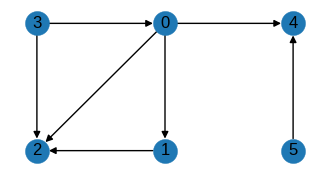

In [4]:
def sample_digraph():
    D=nx.DiGraph()
    D.add_edge(0,'1') # why the 1 as a string? Because then it makes a difference whether it's the node number or the node name
    D.add_edge('1',2)
    D.add_edge(3,2)
    D.add_edge(3,0)
    D.add_edge(0,2)
    D.add_edge(0,4)
    D.add_edge(5,4)
    # position dictionary for drawing
    pos={0:(1,1),'1':(1,0),2:(0,0),3:(0,1),4:(2,1),5:(2,0)}
    D.pos=pos
    return D

D=sample_digraph()
fig,ax=plt.subplots(figsize=(4,2))
nx.draw(D,pos=D.pos,ax=ax,with_labels=True)

We look at the adjacency matrix of this toy graph.

In [5]:
nx.adjacency_matrix(sample_digraph()).toarray()

array([[0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

What we see: There is a 1 if row->column, ie, if the vertex corresponding to the row has an *out-going* edge to the column-vertex. For the transition matrix, we'll need to have non-zero entry when there is an *in-going* edge. That is, we'll need to take the transpose when we compute the transition matrix.

So, how do we compute the transition matrix? We start with the (transpose of the) adjacency matrix, and then need to replace the 1-entries by the inverse of the out-degree. We could now step through the non-zero entries of the adjacency matrix (with a <code>for</code>-loop) and write in $1/d^+(v)$. That, however, takes forever. Why? Because that's then pure python-code and python is slow. It's much faster, if we set up a diagonal matrix and then use matrix multiplication -- that is implemented in C and thus a lot faster. There are two more issues. First, some vertex may be a *sink*, a vertex without any out-going edge. There, $1/d^+(v)$ would be infinite, which is bad. Thus, we need to make sure that we fill in a zero for every sink. We do that with a bit of <code>numpy</code> magic; see [here](https://numpy.org/doc/stable/reference/generated/numpy.divide.html). Second, the adjacency is a *sparse* matrix. That means, only the non-zero entries are stored (which is good, because we have a lot of vertices). For that reason we also set up a *sparse* diagonal matrix. (Probably not necessary, but I was too lazy to check.)

In [6]:
def get_transition_matrix(digraph):
    T=nx.adjacency_matrix(digraph,dtype='float').T # take the transpose; also matrix should contain float entries, not integer entries
    out_degrees=np.array([d for _,d in digraph.out_degree],dtype='float')
    D=sp.diags(np.divide(1.,out_degrees,out=np.zeros_like(out_degrees), where=out_degrees!=0)) # diagonal matrix of reciprocal out-degrees
    return T@D

# let's try out with the toy graph
np.round(get_transition_matrix(sample_digraph()).toarray(),3)

array([[0.   , 0.   , 0.   , 0.5  , 0.   , 0.   ],
       [0.333, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.333, 1.   , 0.   , 0.5  , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.333, 0.   , 0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

Seems fine for the toy graph.

Next, we implement a uniform start distribution (see <code>uniform</code>) and the actual iteration with the page rank matrix
$$
P=(1-\alpha)T+\alpha\tfrac{1}{n}J
$$
in the method <code>iterate</code>. 

There's one hick: Probability mass is lost in sinks. Indeed, if you think about the random process, when the surfer ends up in a sink then it breaks down. Where is the surfer supposed to go in the next step? The solution is as follows: in the next step the surfer chooses any vertex uniformly at random to continue their journey. We could fix that by filling in $\tfrac{1}{n}1$ in every sink-column of $T$. That, however, is uneccessary computation time as we can simply record the sinks then determine the *lost* probability mass as follows
$$
\text{lost}=\sum_{s \text{ sink}}\pi^{(i)}_s
$$
We then add $\text{lost}/n$ to every entry of the distribution (well, weighted with $1-\alpha$ as this is lost in $(1-\alpha)T\pi^{(i-1)}$).

Finally, we keep track of 
$$
||\pi^{(i-1)}-\pi^{(i)}||
$$
to see whether the iteration converges.

In [7]:
def uniform(digraph):
    n=digraph.number_of_nodes()
    return np.ones(n)/n    

def __iterate(T,sinks,pi,alpha,steps,chatty=True):
    """
    sinks: array with indices of zero columns
    """
    diffs=[]
    n=len(pi)
    if chatty:
        start=time.time()
        print("start iteration...",end='')
    for _ in range(steps):
        lost_mass=np.sum(pi[sinks]) # lost probability mass due to sinks
        new_pi=(1-alpha)*(T@pi)+alpha/n+(1-alpha)*lost_mass/n
        diffs.append(math.sqrt(((pi-new_pi)**2).sum()))
        pi=new_pi
    if chatty:
        print("done: {:.0f}s".format(time.time()-start))
    return pi,diffs

def iterate(digraph,steps,alpha=0.15,pi=None,chatty=True):
    if chatty:
        start=time.time()
        print("computing transition matrix...",end='')
    T=get_transition_matrix(digraph)
    if chatty:
        print("done: {:.0f}s".format(time.time()-start))
    print()
    # find the sinks. note: we need the column indices, not the _names_ of the nodes
    sinks=[i for i,v in enumerate(digraph.nodes) if digraph.out_degree[v]==0]
    if pi is None:
        pi=uniform(digraph)
    return __iterate(T,sinks,pi,alpha,steps,chatty=chatty)

# run the computation for 20 steps
pi_star,diffs=iterate(G,20)

computing transition matrix...done: 10s

start iteration...done: 0s


That didn't take too long. We plot the differences $||\pi^{(i-1)}-\pi^{(i)}||$ to see whether the distribution converges.

Text(0.5, 1.0, 'convergence of distribution')

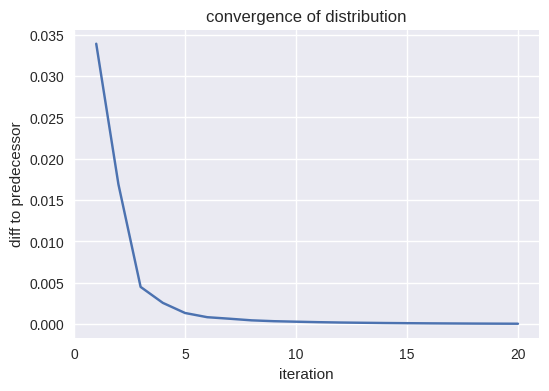

In [8]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(range(1,len(diffs)+1),diffs)
ax.set_xticks(range(0,len(diffs)+1,5))
ax.set_xlabel("iteration")
ax.set_ylabel("diff to predecessor")
ax.set_title("convergence of distribution")

Very nice and fast convergence. 

Let's also look at the entries of the limit distribution $\pi^*$.

Text(0.5, 0, 'probability')

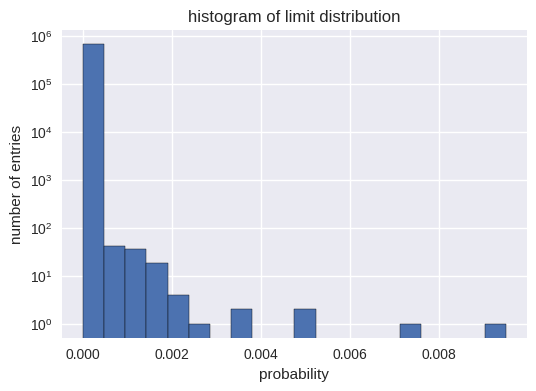

In [9]:
fig,ax=plt.subplots(figsize=(6,4))
ax.hist(pi_star,log=True,edgecolor='k',bins=20)
ax.set_title("histogram of limit distribution")
ax.set_ylabel("number of entries")
ax.set_xlabel("probability")

What we see: most entries have a very small probability; only a few have larger probabilities. That's really what we would expect: a few sites (the landing page, for instance) dominate the others.